<a href="https://colab.research.google.com/github/okchang95/aiffel_quest/blob/main/ex1_2_2_bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2-2 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명? [프로젝트] < 11/20(월) >

Dataset Description : [Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand/data)

데이터셋의 주제는 시간, 온도, 습도, 계절 등의 정보가 담긴 데이터를 통해 자전거의 대여량을 예측하는 문제입니다.<br>
자전거 대여량을 결정하는 데에는 시간도 중요할 것이고, 요일이나 계절도 크게 영향을 미칠 것 같습니다.

이번 프로젝트에서는 직접 손실함수와 기울기를 계산하지 않고, 사이킷런(sklearn)의 LinearRegression 모델을 활용할 것입니다.

In [1]:
# 라이브러리
import pandas as pd


### (1) 데이터 가져오기

- 터미널에서 ~/data/data/bike-sharing-demand 경로에 train.csv 데이터를 train 변수로 가져 옵니다.


In [2]:
# 드라이브 연결

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 파일 변수에 할당
file_path = '/content/drive/MyDrive/aiffel/ex1/data/bike-sharing-demand/'
train = pd.read_csv(file_path + 'train.csv')
test = pd.read_csv(file_path + 'test.csv')
#submission = pd.read_csv(file_path + 'Submission.csv')

In [6]:
# 데이터 확인

train.shape # (10886, 12)
train.info()
train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### (2) datetime 컬럼을 datetime 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기

to_datetime 활용 : [링크](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html#pandas.to_datetime) 참조<br>
pandas datetime extract year month day 키워드로 검색해 보기


In [7]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [8]:
train['datetime'] = pd.to_datetime(train['datetime'])

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

# 날짜컬럼 앞으로 가져오기
#train = train[['datetime', 'year', 'month', 'day', 'hour', 'minute', 'second','season', 'holiday', 'workingday', 'weather', 'temp',
#       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']]


In [9]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


### (3) year, month, day, hour, minute, second 데이터 개수 시각화하기

sns.countplot 활용해서 시각화하기<br>
subplot을 활용해서 한 번에 6개의 그래프 함께 시각화하기


<Axes: xlabel='second', ylabel='count'>

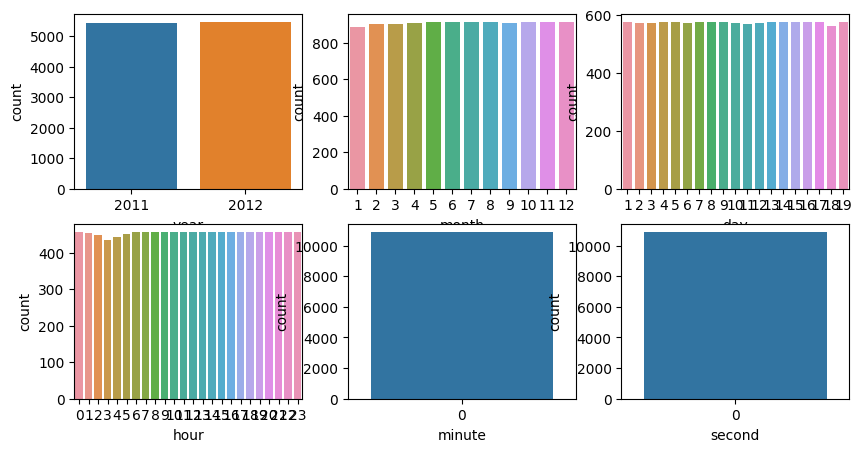

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.countplot(data=train[['year', 'month', 'day', 'hour', 'minute', 'second']])

figure, axes = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(10,5)
sns.countplot(x='year', data=train, ax=axes[0, 0])
sns.countplot(x='month', data=train, ax=axes[0, 1])
sns.countplot(x='day', data=train, ax=axes[0, 2])
sns.countplot(x='hour', data=train, ax=axes[1, 0])
sns.countplot(x='minute', data=train, ax=axes[1, 1])
sns.countplot(x='second', data=train, ax=axes[1, 2])



### (4) X, y 컬럼 선택 및 train/test 데이터 분리
- X(feature) 에는 어떤 데이터 컬럼을 넣어야 될지 고민해 봅시다 데이터 컬럼을 추가하거나 빼면서 잘 조합하여 데이터를 넣기 바랍니다. 만일 모든 데이터 컬럼(특징)을 넣는다면 오차 값이 말도 안 되게 적게 나올 수도 있습니다. ex) count를 예측하는데 casual,registered 컬럼이 필요할까요?

- count 값을 맞추고자 하므로, y 변수에 count 컬럼의 데이터 넣기

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
 16  minute      10886 non-

In [36]:
X = train.drop(columns = ['datetime', 'casual', 'registered', 'minute', 'second'])
y = train['count']


In [40]:
y.shape

(10886,)

In [41]:
# X와 y 데이터를 각각 train 데이터와 test 데이터로 분리해주세요.

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:

X_train.shape # (8708, 13)
X_val.shape # (2178, 13)

y_train.shape # (8708,)
y_val.shape # ((2178,)


(2178,)

### (5) LinearRegression 모델 학습
- sklearn의 LinearRegression 모델 불러오기 및 학습하기

In [48]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

### (6) 학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산

- 학습된 모델에 X_test를 입력해서 예측값 출력하기
- 모델이 예측한 값과 정답 target 간의 손실함수 값 계산하기
- mse 값과 함께 rmse 값도 계산하기

In [ ]:
from sklearn.metrics import mean_squared_error,

### (7) x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화하기
- x축에 X 데이터 중 temp 데이터를, y축에는 count 데이터를 넣어서 시각화하기
- x축에 X 데이터 중 humidity 데이터를, y축에는 count 데이터를 넣어서 시각화하기